<a href="https://colab.research.google.com/github/adrianbruegger/applieddatascience/blob/working_model_integrated_game/AppliedDataScience_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#use a pretrained model(week6 ADS): https://tfhub.dev/tensorflow/tfjs-model/posenet/resnet50/quantized/1/1/default/1

# Kaggle API


In [ ]:
#This cell has to be runned when you want to upload the API token file to google colab, cell below if local
#if you use a local jupyter notebook the kaggle.json has to be in the following path --> C:\Users\User\.kaggle

from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 68 bytes


In [ ]:
#use this cell if you working local and if you work in google colab use the cell above
# Then move kaggle.json into the folder where the API expects to find it.
#!pip install kaggle 
#freigeben falls zum ersten Mal
import kaggle
#!mkdir -p ~\.kaggle\ && move kaggle.json \.kaggle\ && chmod 600 ~\.kaggle\kaggle.json 
# move anstelle von mv verwenden bei Windows

#wenn / gemäss Internet \ verwenden, da Syntax nicht korrekt, jedoch weiter Warnungen...

In [ ]:
#search for a dataset
!kaggle datasets list -s 'rock-paper-scissor'



ref                                                             title                                          size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------  --------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
datasets/frtgnn/rock-paper-scissor                              Rock - Paper - Scissor                        220MB  2019-11-07 17:52:43            475         81  0.6875           
datasets/drgfreeman/rockpaperscissors                           Rock-Paper-Scissors Images                    306MB  2019-03-01 01:01:11           8439        148  0.875            
datasets/sanikamal/rock-paper-scissors-dataset                  Rock Paper Scissors Dataset                   452MB  2019-04-24 19:53:04           2791         61  0.875            
datasets/glushko/rock-paper-scissors-dataset                    Rock, Paper, Scissors Data

In [ ]:
#download multiple datasets
!kaggle datasets download -d drgfreeman/rockpaperscissors
!kaggle datasets download -d anirudhabhagwat/rock-paper-scissors-images 
!kaggle datasets download -d shounakdesai/rock-paper-and-scissor-images 
!kaggle datasets download -d alishmanandhar/rock-scissor-paper 
#Name ohne '' gemacht, damit es funktioniert hat...

 94% 289M/306M [00:03<00:00, 95.8MB/s]
100% 306M/306M [00:03<00:00, 96.5MB/s]
 96% 217M/226M [00:02<00:00, 104MB/s] 
100% 226M/226M [00:02<00:00, 94.6MB/s]
100% 35.4M/35.4M [00:00<00:00, 152MB/s] 
100% 35.4M/35.4M [00:00<00:00, 127MB/s]
100% 497M/498M [00:05<00:00, 138MB/s]
100% 498M/498M [00:05<00:00, 104MB/s]


# Scraping for each category

In [ ]:
from bs4 import BeautifulSoup
import requests

#set page url 

URL = "https://www.google.com/search?q=rock-paper-scissors+hand+sign&tbm=isch&ved=2ahUKEwiphtPg4J_3AhVN3IUKHe6hD5AQ2-cCegQIABAA&oq=rock-paper-scissors+hand+sign&gs_lcp=CgNpbWcQAzIECAAQHjIGCAAQCBAeOgcIIxDvAxAnOggIABAIEB4QEzoGCAAQBxAeOgQIABATOggIABAHEB4QEzoICAAQCBAHEB5QvgZY01VgildoEHAAeACAAfgBiAHwGJIBBjI5LjUuMpgBAKABAaoBC2d3cy13aXotaW1nwAEB&sclient=img&ei=JnleYqnbAs24lwTuw76ACQ&bih=831&biw=1680&rlz=1C5CHFA_enCH928CH928"
page = requests.get(URL)


soup = BeautifulSoup(page.content, 'html.parser')

#find all urls in img-tag <img> with class="yWs4tf"
image_tags = soup.find_all('img', class_='yWs4tf')


#add all urls to links-dict
links = []
for image_tag in image_tags:
    links.append(image_tag['src'])

#request all pictures and save

import urllib.request
for i, url in enumerate(links):
    urllib.request.urlretrieve(url, str('photo_' + str(i+1) + '.jpg'))

### Zip-File etc.

In [ ]:
# TensorFlow and tf.keras
#!pip install tensorflow
#! pip install tensorflow_datasets
import tensorflow as tf
import os

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import PIL
import PIL.Image
import tensorflow_datasets as tfds

print(tf.__version__)
print(tf.config.list_physical_devices())

2.8.0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


In [ ]:
#setup folder where you will save logs for tensorflow 
root_logdir = os.path.join(os.curdir,"my_logs_project")


def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()

In [ ]:
from zipfile import ZipFile

# Create a ZipFile Object and load file.zip in it for first dataset
with ZipFile('rockpaperscissors.zip', 'r') as zipObj:
    # Extract all the contents of zip file in current directory
   zipObj.extractall('rockpaperscissors')

#for 2.dataset
with ZipFile('rock-paper-and-scissor-images.zip', 'r') as zipObj:
    # Extract all the contents of zip file in current directory
   zipObj.extractall('rockpaperscissors')

#for 3.dataset
with ZipFile('rock-paper-scissors-images.zip', 'r') as zipObj:
    # Extract all the contents of zip file in current directory
   zipObj.extractall('rockpaperscissors')

with ZipFile('rock-scissor-paper.zip', 'r') as zipObj:
    # Extract all the contents of zip file in current directory
   zipObj.extractall('rockpaperscissors')


### Data cleaning

In [ ]:
import shutil
import os
#remove unnötige Folder

# location
location = 'rockpaperscissors'
   
# director
dir = 'rps-cv-images'
   
# path
path = os.path.join(location, dir)   
# removing directory
shutil.rmtree(path)
shutil.rmtree("/content/rockpaperscissors/final/valid")
shutil.rmtree("/content/rockpaperscissors/final/train")



In [ ]:
#move folders to the target folder for dataset 2

original = r'/content/rockpaperscissors/image_data/paper'
target = r'rockpaperscissors/paper'

shutil.move(original, target)

original = r'/content/rockpaperscissors/image_data/rock'
target = r'rockpaperscissors/rock'

shutil.move(original, target)

original = r'/content/rockpaperscissors/image_data/scissors'
target = r'rockpaperscissors/scissors'

shutil.move(original, target)

original = r'/content/rockpaperscissors/final/final/train/c0'
target = r'rockpaperscissors/rock'

shutil.move(original, target)

original = r'/content/rockpaperscissors/final/final/train/c1'
target = r'rockpaperscissors/paper'

shutil.move(original, target)

original = r'/content/rockpaperscissors/final/final/train/c2'
target = r'rockpaperscissors/scissors'

shutil.move(original, target)

# location
location = 'rockpaperscissors'
   
# director
dir = 'image_data'
   
# path
path = os.path.join(location, dir)   
# removing directory
shutil.rmtree(path)

# location
location = 'rockpaperscissors'
   
# director
dir = 'final'
   
# path
path = os.path.join(location, dir)   
# removing directory
shutil.rmtree(path)

Error: ignored

In [ ]:
#move folders to the target folder for dataset 3

original1 = r'rockpaperscissors/final_data/paper'
target1 = r'rockpaperscissors/paper/paper'
shutil.move(original1, target1+'_2')

original2 = r'rockpaperscissors/final_data/rock'
target2 = r'rockpaperscissors/rock/rock'

shutil.move(original2, target2+'_2')

original3 = r'rockpaperscissors/final_data/scissors'
target3 = r'rockpaperscissors/scissors/scissors'

shutil.move(original3, target3+'_2')

# location
location = 'rockpaperscissors'
   
# director
dir = 'final_data'
   
# path
path = os.path.join(location, dir)   
# removing directory
shutil.rmtree(path)


FileNotFoundError: ignored

In [ ]:
#move subfolders to main folders and delete subfolders

# Define the source and destination path
source = r'rockpaperscissors/scissors/scissors'
destination = r'rockpaperscissors/scissors'
  
# code to move the files from sub-folder to main folder.
files = os.listdir(source)
for file in files:
    file_name = os.path.join(source, file)
    shutil.move(file_name, destination)
print("Files Moved")

shutil.rmtree(source)

# Define the source and destination path
source2 = r'rockpaperscissors/scissors/scissors_2'
destination2 = r'rockpaperscissors/scissors'
  
# code to move the files from sub-folder to main folder.
files = os.listdir(source2)
for file in files:
    file_name = os.path.join(source2, file)
    shutil.move(file_name, destination2)
print("Files Moved")

shutil.rmtree(source2)

# Define the source and destination path
source3 = r'rockpaperscissors/rock/rock'
destination3 = r'rockpaperscissors/rock'
  
# code to move the files from sub-folder to main folder.
files = os.listdir(source3)
for file in files:
    file_name = os.path.join(source3, file)
    shutil.move(file_name, destination3)
print("Files Moved")

shutil.rmtree(source3)

# Define the source and destination path
source4 = r'rockpaperscissors/rock/rock_2'
destination4 = r'rockpaperscissors/rock'
  
# code to move the files from sub-folder to main folder.
files = os.listdir(source4)
for file in files:
    file_name = os.path.join(source4, file)
    shutil.move(file_name, destination4)
print("Files Moved")

shutil.rmtree(source4)


# Define the source and destination path
source5 = r'rockpaperscissors/paper/paper'
destination5 = r'rockpaperscissors/paper'
  
# code to move the files from sub-folder to main folder.
files = os.listdir(source5)
for file in files:
    file_name = os.path.join(source5, file)
    shutil.move(file_name, destination5)
print("Files Moved")

shutil.rmtree(source5)


# Define the source and destination path
source6 = r'rockpaperscissors/paper/paper_2'
destination6 = r'rockpaperscissors/paper'
  
# code to move the files from sub-folder to main folder.
files = os.listdir(source6)
for file in files:
    file_name = os.path.join(source6, file)
    shutil.move(file_name, destination6)
print("Files Moved")

shutil.rmtree(source6)

# Define the source and destination path
source7 = r'rockpaperscissors/paper/c1'
destination7 = r'rockpaperscissors/paper'
  
# code to move the files from sub-folder to main folder.
files = os.listdir(source7)
for file in files:
    file_name = os.path.join(source7, file)
    shutil.move(file_name, destination7)
print("Files Moved")

shutil.rmtree(source7)

# Define the source and destination path
source8 = r'rockpaperscissors/rock/c0'
destination8 = r'rockpaperscissors/rock'
  
# code to move the files from sub-folder to main folder.
files = os.listdir(source8)
for file in files:
    file_name = os.path.join(source8, file)
    shutil.move(file_name, destination8)
print("Files Moved")

shutil.rmtree(source8)


# Define the source and destination path
source9 = r'rockpaperscissors/scissors/c2'
destination9 = r'rockpaperscissors/scissors'
  
# code to move the files from sub-folder to main folder.
files = os.listdir(source9)
for file in files:
    file_name = os.path.join(source9, file)
    shutil.move(file_name, destination9)
print("Files Moved")

shutil.rmtree(source9)

Files Moved
Files Moved
Files Moved
Files Moved
Files Moved
Files Moved
Files Moved
Files Moved
Files Moved


In [ ]:
# zwei Gif-files welche zu bereinigen sind, funktioniert noch nicht
os.remove('rockpaperscissors/rock/png_to_gif.gif')
os.remove('rockpaperscissors/rock/dcgan.gif')

### Resize Images

In [ ]:
# nächste Blöcke funktionieren und size wird auf 192 192 reduziert, jedoch Meldung jeweils Bad file... Code könnte schlanker ausgestaltet werden jedoch unklar wie

#in google colab funktioniert der code nur mit PIL. vor Image.open
import glob
dst_dir = 'rockpaperscissors/rock'
os.makedirs(dst_dir, exist_ok=True)

files = glob.glob('./rockpaperscissors/rock/*')
i = 0

for f in files: 
    i = i + 1
    try:
        img = PIL.Image.open('rockpaperscissors/rock/'+f)
    except (IOError) as e:
        print ('Bad file:', f)
        pass
    img = PIL.Image.open(f)
    if img.mode != 'RGB':
        img = img.convert('RGB')
    img_resize = img.resize((192, 192))
    root, ext = os.path.splitext(f)
    basename = os.path.basename(root)
    img_resize.save(os.path.join(dst_dir, basename + ext))
    if i == 10000:
        print("over >10'000 process aborted")
        break

Bad file: ./rockpaperscissors/rock/image (802).jpg
Bad file: ./rockpaperscissors/rock/whv9ZooPZNEjStCk.png
Bad file: ./rockpaperscissors/rock/image (1470).jpg
Bad file: ./rockpaperscissors/rock/image (782).jpg
Bad file: ./rockpaperscissors/rock/image (234).jpg
Bad file: ./rockpaperscissors/rock/20180327131015-Rock-7d58d4dd12007de5.jpg
Bad file: ./rockpaperscissors/rock/image (1059).jpg
Bad file: ./rockpaperscissors/rock/M5FhZFlXsmRMTHkc.png
Bad file: ./rockpaperscissors/rock/5sdSnAPfphSzXjWu.png
Bad file: ./rockpaperscissors/rock/724DhutGELMHY1uD.png
Bad file: ./rockpaperscissors/rock/TLbqMqwDrww8CS0p.png
Bad file: ./rockpaperscissors/rock/image (980).jpg
Bad file: ./rockpaperscissors/rock/image (1527).jpg
Bad file: ./rockpaperscissors/rock/muKpkJF3C3j0TmAN.png
Bad file: ./rockpaperscissors/rock/image (341).jpg
Bad file: ./rockpaperscissors/rock/image (262).jpg
Bad file: ./rockpaperscissors/rock/zp7Okc8j1CJgB8ji.png
Bad file: ./rockpaperscissors/rock/image (1228).jpg
Bad file: ./rockpa

In [ ]:
dst_dir = 'rockpaperscissors/paper'
os.makedirs(dst_dir, exist_ok=True)

files = glob.glob('./rockpaperscissors/paper/*')
i = 0

for f in files: 
    i = i + 1
    try:
        img = PIL.Image.open('rockpaperscissors/paper/'+f)
    except (IOError) as e:
        print ('Bad file:', f)
        pass
    img = PIL.Image.open(f)
    if img.mode != 'RGB':
        img = img.convert('RGB')
    img_resize = img.resize((192, 192))
    root, ext = os.path.splitext(f)
    basename = os.path.basename(root)
    img_resize.save(os.path.join(dst_dir, basename + ext))
    if i == 10000:
        print("over >10'000 process aborted")
        break

Bad file: ./rockpaperscissors/paper/image (802).jpg
Bad file: ./rockpaperscissors/paper/20180327132200-Paper-7d58d4dd12007de5.jpg
Bad file: ./rockpaperscissors/paper/image (1470).jpg
Bad file: ./rockpaperscissors/paper/image (782).jpg
Bad file: ./rockpaperscissors/paper/image (234).jpg
Bad file: ./rockpaperscissors/paper/image (1059).jpg
Bad file: ./rockpaperscissors/paper/image (980).jpg
Bad file: ./rockpaperscissors/paper/image (1527).jpg
Bad file: ./rockpaperscissors/paper/image (341).jpg
Bad file: ./rockpaperscissors/paper/image (262).jpg
Bad file: ./rockpaperscissors/paper/image (1228).jpg
Bad file: ./rockpaperscissors/paper/image (532).jpg
Bad file: ./rockpaperscissors/paper/IMG_4834.jpg
Bad file: ./rockpaperscissors/paper/image (406).jpg
Bad file: ./rockpaperscissors/paper/20170705_122253.jpg
Bad file: ./rockpaperscissors/paper/20180327130453-Paper-fd3b563d3a42d605.jpg
Bad file: ./rockpaperscissors/paper/7PSJU8kbZf8S6FRW.png
Bad file: ./rockpaperscissors/paper/hfYfNNtqkFzF9BE4.p

In [ ]:
dst_dir = 'rockpaperscissors/scissors'
os.makedirs(dst_dir, exist_ok=True)

files = glob.glob('./rockpaperscissors/scissors/*')
i = 0

for f in files: 
    i = i + 1
    try:
        img = PIL.Image.open('rockpaperscissors/scissors/'+f)
    except (IOError) as e:
        print ('Bad file:', f)
        pass
    img = PIL.Image.open(f)
    if img.mode != 'RGB':
        img = img.convert('RGB')
    img_resize = img.resize((192, 192))
    root, ext = os.path.splitext(f)
    basename = os.path.basename(root)
    img_resize.save(os.path.join(dst_dir, basename + ext))
    if i == 10000:
        print("over >10'000 process aborted")
        break

Bad file: ./rockpaperscissors/scissors/image (802).jpg
Bad file: ./rockpaperscissors/scissors/image (1470).jpg
Bad file: ./rockpaperscissors/scissors/image (782).jpg
Bad file: ./rockpaperscissors/scissors/image (234).jpg
Bad file: ./rockpaperscissors/scissors/image (1059).jpg
Bad file: ./rockpaperscissors/scissors/image (980).jpg
Bad file: ./rockpaperscissors/scissors/image (1527).jpg
Bad file: ./rockpaperscissors/scissors/image (341).jpg
Bad file: ./rockpaperscissors/scissors/itXNIVO7ghl2qja8.png
Bad file: ./rockpaperscissors/scissors/image (262).jpg
Bad file: ./rockpaperscissors/scissors/20180219134543-Scissors-d10227e15e2074d5.jpg
Bad file: ./rockpaperscissors/scissors/image (1228).jpg
Bad file: ./rockpaperscissors/scissors/image (532).jpg
Bad file: ./rockpaperscissors/scissors/Zz1djgkAdRqsHM3z.png
Bad file: ./rockpaperscissors/scissors/R9xpzPuawT5aH69c.png
Bad file: ./rockpaperscissors/scissors/20170914_115607.jpg
Bad file: ./rockpaperscissors/scissors/image (406).jpg
Bad file: ./r

### Data for Classification with Transfer Learning & Fine Tuning

In [ ]:
# .ipynb_checkpoint is falsely recognized as class, so we have to remove it before continuing

#shutil.rmtree('/content/rockpaperscissors/.ipynb_checkpoints', ignore_errors=True)

data_dir = os.path.join(os.curdir, '/content/rockpaperscissors')
                        
batch_size = 32
img_height = 180
img_width = 180

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 10500 files belonging to 3 classes.
Using 8400 files for training.
Found 10500 files belonging to 3 classes.
Using 2100 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['paper', 'rock', 'scissors']


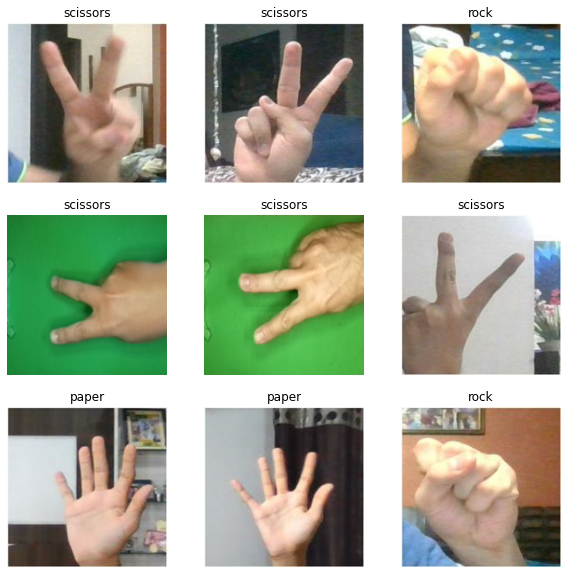

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

### Configure the dataset for performance

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Standardize Data

In [ ]:
from tensorflow.keras import layers
normalization_layer = layers.Rescaling(1./255)


In [ ]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0005359414 0.95085406


### Create the model

In [ ]:
from tensorflow.keras.models import Sequential

num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

## Data augementation

#### https://www.tensorflow.org/tutorials/images/data_augmentation

In [ ]:
from tensorflow.keras.models import Sequential


data_augmentation = tf.keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

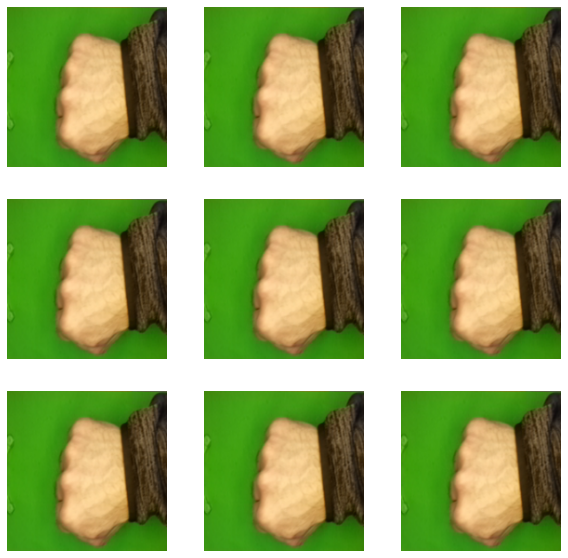

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

Compile the model

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Model summary

In [ ]:
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 45, 45, 32)       

In [ ]:
epochs=2
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/2
263/263 [==============================] - 204s 771ms/step - loss: 0.6214 - accuracy: 0.7468 - val_loss: 0.3829 - val_accuracy: 0.8490
Epoch 2/2
263/263 [==============================] - 202s 769ms/step - loss: 0.2934 - accuracy: 0.8835 - val_loss: 0.3570 - val_accuracy: 0.8514


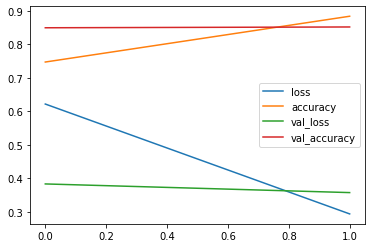

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

pd.DataFrame(history.history).plot()
plt.show()

#### Compile the mode

## Fine tuning

### Evaluation and prediction

In [ ]:
test_loss, test_acc = model.evaluate(val_ds, verbose=2)

print('\nTest accuracy:', test_acc)

##loss, accuracy = model.evaluate(val_ds)
##print('Test accuracy :', accuracy)

66/66 - 13s - loss: 0.3570 - accuracy: 0.8514 - 13s/epoch - 194ms/step

Test accuracy: 0.8514285683631897


Predictions:
 [0 1 1 0 1 1 0 0 1 1 1 0 0 1 1 0 1 0 0 1 0 0 1 0 0 1 1 1 0 1 1 1 0 0 1 0 0
 0 1 0 1 0 1 1 0 0 1 1 0 1 1 0 0 1 0 1 1 1 1 0 0 1 1 1 0 1 1 1 1 0 1 1 0 0
 1 0 1 0 1 1 0 0 1 1 1 1 0 1 1 1 1 1 1 1 1 0]
Labels:
 [2 1 2 1 2 1 1 1 1 2 1 1 2 1 0 0 1 2 2 1 1 1 1 2 2 1 0 2 0 2 0 0]


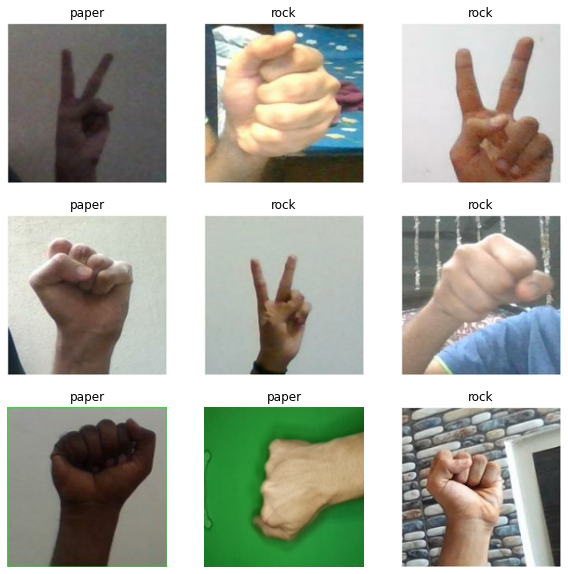

In [ ]:
# Retrieve a batch of images from the test set
image_batch, label_batch = val_ds.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

In [ ]:
model.save("rockpaperscissors.h5")

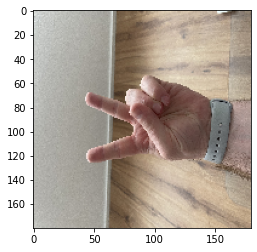

This image most likely belongs to scissors with a 88.02 percent confidence.
scissors


In [ ]:
sunflower_url = "/content/"
sunflower_path = "/content/IMG_0961.jpg"

img = tf.keras.utils.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

imgplot = plt.imshow(img)
plt.show()

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)
print(class_names[np.argmax(score)])

<IPython.core.display.Javascript object>

/content/photo.jpg


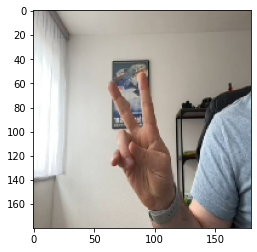

This image most likely belongs to scissors with a 96.07 percent confidence.
scissors

You chose scissors, computer chose scissors.

Both players selected scissors. It's a tie!
Play again? (y/n): y


<IPython.core.display.Javascript object>

/content/photo.jpg


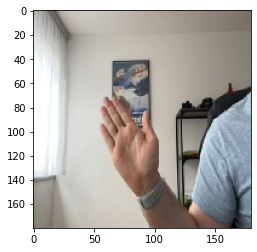

This image most likely belongs to scissors with a 89.44 percent confidence.
scissors

You chose scissors, computer chose scissors.

Both players selected scissors. It's a tie!
Play again? (y/n): y


<IPython.core.display.Javascript object>

/content/photo.jpg


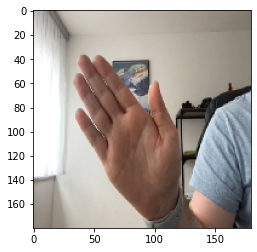

This image most likely belongs to rock with a 80.55 percent confidence.
rock

You chose rock, computer chose rock.

Both players selected rock. It's a tie!
Play again? (y/n): y


<IPython.core.display.Javascript object>

/content/photo.jpg


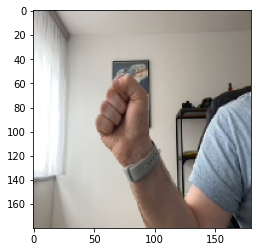

This image most likely belongs to scissors with a 74.57 percent confidence.
scissors

You chose scissors, computer chose rock.

Rock smashes scissors! You lose.
Play again? (y/n): y


<IPython.core.display.Javascript object>

/content/photo.jpg


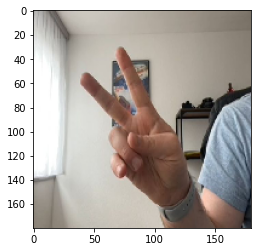

This image most likely belongs to scissors with a 44.47 percent confidence.
scissors

You chose scissors, computer chose paper.

Scissors cuts paper! You win!
Play again? (y/n): y


<IPython.core.display.Javascript object>

/content/photo.jpg


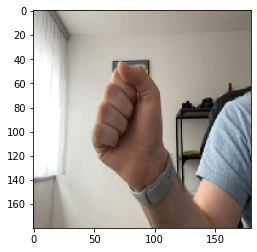

This image most likely belongs to rock with a 50.52 percent confidence.
rock

You chose rock, computer chose paper.

Paper covers rock! You lose.
Play again? (y/n): y


<IPython.core.display.Javascript object>

/content/photo.jpg


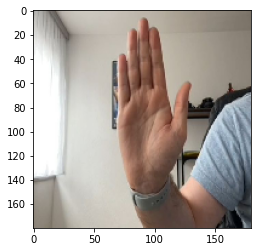

This image most likely belongs to paper with a 43.38 percent confidence.
paper

You chose paper, computer chose scissors.

Scissors cuts paper! You lose.
Play again? (y/n): n


In [ ]:
import random
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
from IPython.display import Image


def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)

  image_path = "/content/" + filename

  print( image_path)

  img = tf.keras.utils.load_img(
    image_path, target_size=(img_height, img_width)
  )
  img_array = tf.keras.utils.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0) # Create a batch

  predictions = model.predict(img_array)
  score = tf.nn.softmax(predictions[0])

  imgplot = plt.imshow(img)
  plt.show()

  print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
  )
  print(class_names[np.argmax(score)])
  return class_names[np.argmax(score)]

#loop to play severals games
while True:
    
    # get the user input
    user_action = take_photo()
    
    # make the computer choose
    possible_actions = ["rock", "paper", "scissors"]
    computer_action = random.choice(possible_actions)
    print(f"\nYou chose {user_action}, computer chose {computer_action}.\n")
    

    # determine a winner
    if user_action == computer_action:
        print(f"Both players selected {user_action}. It's a tie!")
    elif user_action == "rock":
        if computer_action == "scissors":
            print("Rock smashes scissors! You win!")
        else:
            print("Paper covers rock! You lose.")
    elif user_action == "paper":
        if computer_action == "rock":
            print("Paper covers rock! You win!")
        else:
            print("Scissors cuts paper! You lose.")
    elif user_action == "scissors":
        if computer_action == "paper":
            print("Scissors cuts paper! You win!")
        else:
            print("Rock smashes scissors! You lose.")
            
    #loop to play severals games
    play_again = input("Play again? (y/n): ")
    if play_again.lower() != "y":
        break

# Use Webcam (works only local)

In [ ]:
model_to_use=tf.keras.models.load_model ("rockpaperscissors.h5")

In [ ]:
#take a picture with the integrated default camera
#pip install opencv-python
import cv2
import pymsgbox as pymsg

#access standard camera 0
videoCaptureObject = cv2.VideoCapture(0)

#show message 
msg = pymsg.alert("A picture was captured with the webcam.", 'Camera')
# OK whatever you type, it will return OK
print(msg)


#loop --> read frame and save it (set value to False)
result = True
contador = 0 
while(result):
    ret,frame = videoCaptureObject.read()
    cv2.imshow("Captura", frame)
    key = cv2.waitKey(1)
    if contador==50:
        cv2.imwrite("NewCamPicture.jpg",frame)
        result = False
    contador=contador+1

# release camera and destroy all windows
videoCaptureObject.release()
cv2.destroyAllWindows()

OK


This image most likely belongs to rock.


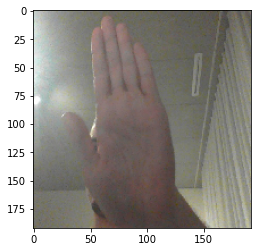

In [ ]:
img = tf.keras.utils.load_img("NewCamPicture.jpg", target_size=(192,192)# your own image
)

img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Add the image to a batch where it's the only member.


prediction = model.predict_on_batch(img_array).flatten()

prediction = tf.where(prediction < 0.5, 0, 1)


print(
    "This image most likely belongs to {}."
    .format(class_names[prediction[0]])
)

plt.imshow(img)